## European Cash Denomination Recognition
----



#### Problem Statement:
* To Build a system that recognize different cash denomination, people can make a cash deposite in a bank machine or make a purchase using vending machine both the system have to determine the amount  of money you've deposited in them automatically. ATM uses human to verify the amount. To know possible problems with depositing checks through an ATM https://money.howstuffworks.com/personal-finance/online-banking/deposit-checks-through-atm1.htm

#### Dataset:
* First Source: https://www.ecb.europa.eu/euro/banknotes/images/html/index.en.html

* Second Source: 
1. Training data: https://cocl.us/DL0320EN_TRAIN_TAR_KERAS
2. Validation data: https://cocl.us/DL0320EN_VALID_TAR_KERAS
3. Testing data: https://cocl.us/DL0320EN_TEST_TAR_KERAS

* The Dataset consist of two folders 1) Banknotes ES1 Specimen 72dpi 2) Banknotes ES2 Specimen 72dpi.
* We Need to use Banknotes ES1 Specimen 72dpi for tranining and Banknotes ES2 Specimen 72dpi for testing.
* Another thing to notice is that there are two format been provided one in GIF and other in JPEG hence we can use any one of it.
* Since the dataset is not much hence we can can create sepreate folder for each of the cash demonitaion.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Rescale the image
import os
from PIL import Image

class Rescale:
    '''
    This is the class that will scale the image into the desired specified size
    '''
    def __init__(self,scale_height,scale_width):
        self.scale_height = scale_height
        self.scale_width = scale_width
        
    def rescale(self, path_to_dataset):
        for image in os.listdir(path_to_dataset):
            img = Image.open(path_to_dataset+"\\"+image)
            image_resized = img.resize((self.scale_width,self.scale_height),Image.ANTIALIAS)

            image_resized.save(path_to_dataset+"\\"+image)

### Loading Packages and Dependencies
----

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import numpy as np
import random

In [0]:
train_path = '/content/drive/My Drive/Deep Learning Projects/European Currencies Dataset/Train'
classes = os.listdir(train_path) #getting list of all classes

### Data Visualization
----

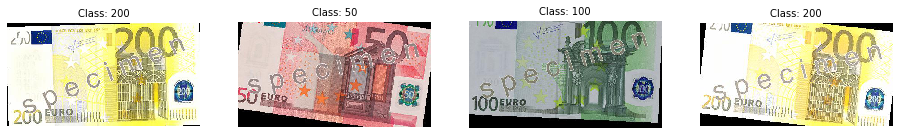

In [7]:
plt.figure(figsize=(20,80))
for image_index in range(0,4):
    t = image_index+1
    random_classes = random.choice(classes)
    path_creation = train_path+'/'+f'{random_classes}'
    random_image = random.choice(os.listdir(path_creation))
    plt.subplot(2,5,t).set_title(f'Class: {random_classes}',fontsize=10)
    plt.axis('off')
    plt.imshow(plt.imread(str(path_creation+"/"+str(random_image))))
plt.show()        

### Image Augmentation
-----

In [0]:
TARGET_SHAPE = (224,224)
SEED = 0
NUM_CLASSES = len(classes)
CLASSES = classes
DIRECTORY_TRAIN = '/content/drive/My Drive/Deep Learning Projects/European Currencies Dataset/Train'
DIRECTORY_VALID = '/content/drive/My Drive/Deep Learning Projects/European Currencies Dataset/Valid'

In [0]:
train_data_generator = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_data_generator = ImageDataGenerator(rescale=1./255)

In [10]:
Train_generator = train_data_generator.flow_from_directory(directory=DIRECTORY_TRAIN,save_format='jpg',target_size=TARGET_SHAPE,seed=SEED,classes=CLASSES)
Valid_generator = valid_data_generator.flow_from_directory(directory=DIRECTORY_VALID,save_format='jpg',target_size=TARGET_SHAPE,seed=SEED,classes=CLASSES)

Found 70 images belonging to 7 classes.
Found 70 images belonging to 7 classes.


### Training The Model
----

In [0]:
vgg_model = VGG16(weights='imagenet',include_top=False, input_shape=(224,224,3)) #Loading the model expect for the final layers
for layers in vgg_model.layers: # freezing all the layers
    layers.trainable = False

In [0]:
def ConstructingTopLayer(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(64, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model

model_output = ConstructingTopLayer(bottom_model=vgg_model, num_classes=NUM_CLASSES)
currency_model = Model(inputs = vgg_model.input, outputs = model_output) 
currency_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
epoch = 30
with tqdm_notebook(total=epoch, unit='epoch') as t:
    def cbk(epoch, logs):
        t.set_postfix(logs, refresh=False)
        t.update()
    cbkWrapped = LambdaCallback(on_epoch_end=cbk)
    currency_mode_history = currency_model.fit_generator(Train_generator,validation_data=Valid_generator,epochs=epoch,verbose=0,callbacks=[cbkWrapped])

### Model Complexity Graph
----

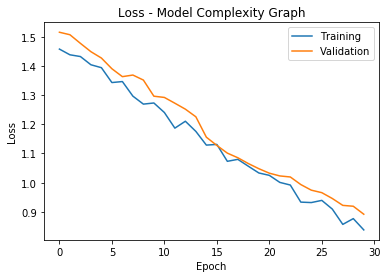

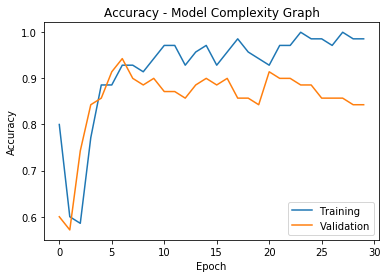

In [0]:
#Loss
plt.plot(currency_mode_history.history['loss'])
plt.plot(currency_mode_history.history['val_loss'])
plt.title('Loss - Model Complexity Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training','Validation'])
plt.show()


#Accuracy
plt.plot(currency_mode_history.history['acc'])
plt.plot(currency_mode_history.history['val_acc'])
plt.title('Accuracy - Model Complexity Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training','Validation'])
plt.show()

### Test Accuracy
----

In [87]:
DIRECTORY_TEST = '/content/drive/My Drive/Deep Learning Projects/European Currencies Dataset/Test'
test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(directory=DIRECTORY_TEST,target_size=TARGET_SHAPE,seed=SEED,classes=CLASSES)
print('Test Accuracy:',round(currency_model.evaluate_generator(test_generator)[1]*100,2),'%')

Found 70 images belonging to 7 classes.
Test Accuracy: 92.86 %


### Model Save and Load
---

In [0]:
currency_model.save('/content/drive/My Drive/Deep Learning Projects/Currency_model1.h5') #Saving the model 

In [0]:
currency_model = load_model('/content/drive/My Drive/Deep Learning Projects/Currency_model1.h5') #Loading the model

### Visualizing Test Result
----

In [0]:
#Using Keract to visualize the result
!pip install keract
!pip install grpcio

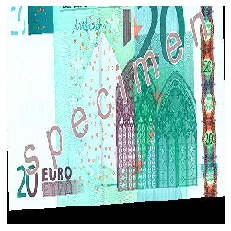

In [112]:
from keract import get_activations,display_activations,display_heatmaps
test_image = test_generator.next()[0][1]
plt.imshow(test_image)
plt.axis('off')
plt.show()

In [113]:
image_reshape = test_image.reshape(1, test_image.shape[0], test_image.shape[1], test_image.shape[2])
predicted = CLASSES[np.argmax(currency_model.predict(image_reshape))]
print('Predicted:',predicted)

Predicted: 20


### Class Activation Map
---


block1_conv1_1 (1, 224, 224, 64) 


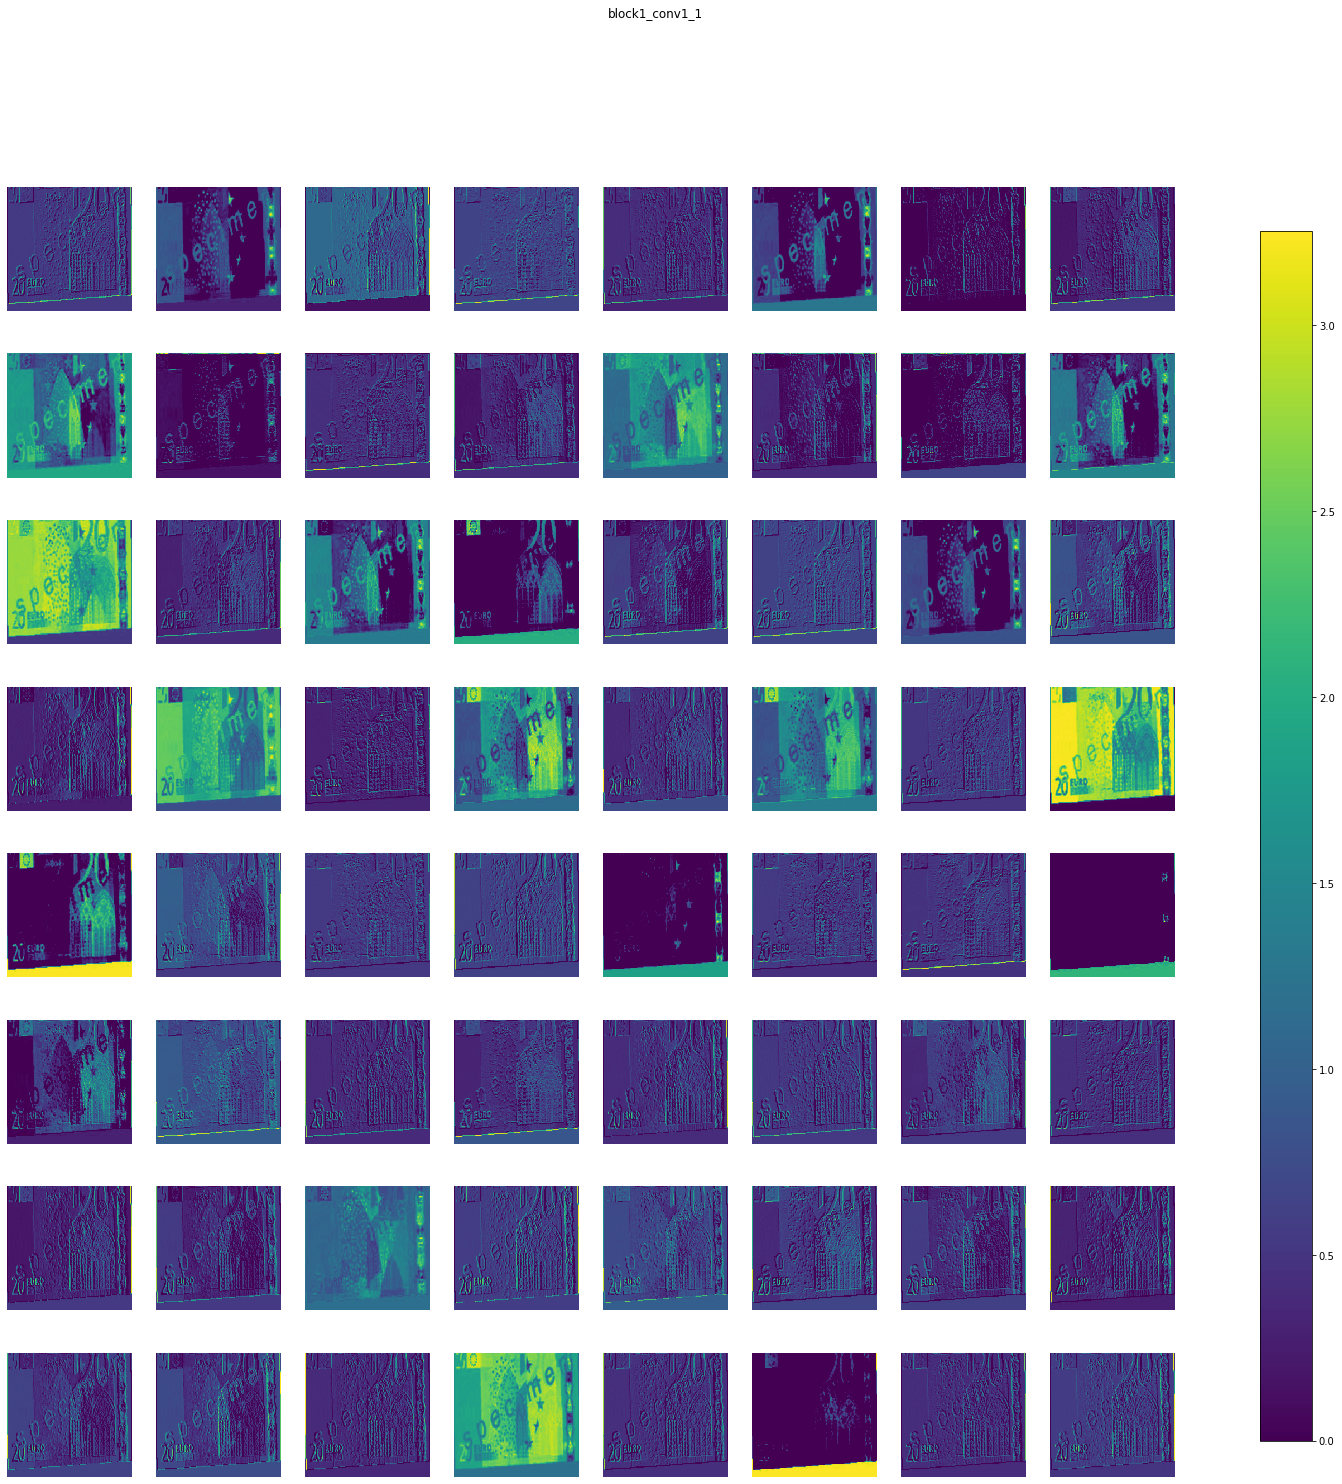

In [114]:
# visualizing the layer 'block1_conv1'
activation = get_activations(currency_model,image_reshape,layer_name='block1_conv1')
display_activations(activation)
# HeatMap
#display_heatmaps(activation,image_reshape,save=False)